# Predicting Categories for Amazon Products

### Abstract

The purpose of this work is to make a predictor which would act as automatic categorizer in online shops. It would work like this: an user wants to sell his watch, so he/she takes a picture of it and uploads it to website, which then suggests categories where similar items (in this case) watches usually go and where people would most likely look for them.

## Reading in the metadata

The dataset is provided by Amazon and it's root category where all products fit into is "Clothing_Shoes_and_Jewelry")

In [44]:
import pandas as pd
import gzip

import numpy as np

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('meta_Clothing_Shoes_and_Jewelry.json.gz')

df['categories'] = df['categories'].apply(lambda x: np.concatenate(x))

## Getting available images indexes 

I downloaded just ~60k images (total would have been over 1.5million) because otherwise training would have been computationally slow and expensive.

In [45]:
from os import listdir
from os.path import isfile, join
import urllib.request

mypath = './Images'
#get already existing files
onlyfiles = [int(f.replace(".jpg","")) for f in listdir(mypath) if isfile(join(mypath, f))]



In [46]:
df = df.loc[onlyfiles]

## Preprocessing - checking how balanced dataset is

In [47]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
counts = mlb.fit_transform(df.loc[onlyfiles]['categories'])

In [48]:
categories_indexes = {}

sub_bar_categories = []
for t, col in enumerate(counts.T):
    if(col.sum() > 3000):
        categories_indexes[t] = (col.sum(), np.argwhere(col==1).flatten())
    else:
        sub_bar_categories.append(t)

In [49]:
for key in categories_indexes.keys():
    print(mlb.classes_[key], categories_indexes[key][0])

Accessories 6750
Available for International Shipping 4093
Band & Music Fan 3926
Big & Tall 3684
Clothing 13466
Clothing, Shoes & Jewelry 62270
Costumes & Accessories 4190
Exotic Apparel 3522
Jewelry 13220
Jewelry: International Shipping Available 6840
Men 21962
Novelty 15975
Novelty, Costumes & More 27559
Petite 3871
Shoes 15710
Shoes & Accessories: International Shipping Available 12561
Sports & Outdoors 4991
Watches 7567
Women 30535
Wrist Watches 7376


As can be seen above Some categories are too shallow and upper level ("Clothing, Shoes & Jewelry", "Novelty, Costumes & More", etc) which would add nothing in value.

## Remove all non-relevant categories

In [50]:
classes = [mlb.classes_[key] for key in categories_indexes.keys()]

# these classes add nothing in value or are too large, so remove them
classes.remove('Clothing, Shoes & Jewelry')
classes.remove('Novelty, Costumes & More')
classes.remove("Watches")
classes.remove("Novelty")
# classes.remove("Available for International Shipping")
classes.remove("Accessories")
classes.remove("Clothing")
classes.remove('Women')
classes.remove('Men')
classes.remove("Costumes & Accessories")
classes.remove("Available for International Shipping")
classes.remove("Jewelry: International Shipping Available")
classes.remove("Shoes & Accessories: International Shipping Available")

df['categories'] = df['categories'].apply(lambda x: np.intersect1d(x, classes))

I can only use images with just one category, because I use ImageDataGenerator which expects each sample to belong into just one class.

In [51]:
#remove products which aren't from any specified classes
df = df[df['categories'].apply(lambda x: x.size == 1)]

#final shape
df.shape

(42442, 9)

In [52]:
df['categories'] = df['categories'].apply(lambda x: x[0])

In [53]:
df['categories'].unique()

array(['Wrist Watches', 'Shoes', 'Petite', 'Jewelry', 'Sports & Outdoors',
       'Exotic Apparel', 'Band & Music Fan', 'Big & Tall'], dtype=object)

In [54]:
df = df.reset_index()

## Dividing dataset into test and train sets

Divide images into training, test and validation sets in stratified fashion.

In [65]:
train_indices = []
validation_indices = []
test_indices = []

for name, group in df.groupby('categories'):
    # 80% training, 20% test
    train_size = int(group.shape[0] *0.8)
    
    
    sub_train = np.random.choice(group.index, train_size, replace=False)
    test_indices.extend(np.setdiff1d(group.index, sub_train))

    # 80% of training as training set and 20% validation set
    val_size = int(train_size *0.2) 
    validation_sub = np.random.choice(sub_train, val_size, replace=False)

    train_indices.extend(np.setdiff1d(sub_train, validation_sub))
    validation_indices.extend(validation_sub)
    
train_indices = np.array(train_indices)
test_indices = np.array(test_indices)
validation_indices = np.array(validation_indices)    


In [66]:
train_indices.shape, test_indices.shape, validation_indices.shape

((27164,), (8491,), (6787,))

## Move images into specific folders

### Create folders

Make separate test, train and validation folders.

In [61]:
import os

try:
    os.makedirs("./train")
except:
    print("directory already exists")
    
try:
    os.makedirs("./val")
except:
    print("directory already exists")
    
try:
    os.makedirs("./test")
except:
    print("directory already exists")


### Create separate folder for each category

I use ImageDataGenerator which let's to read images in batches straight from directory during training and testing but in order for it to work each image has to be in certain subfolder containing only this category images. This is why I could only use products which belong into just one category.
 

In [67]:
import os
import shutil
src = "./Images/"

# target_dir = os.listdir(target)


def move_files(indices, target_folder):
    # create subfolders
    for category in df.loc[indices]['categories'].unique():
        try:
            os.makedirs(target_folder + category)
        except:
            print("directory already exists")

    for name, group in df.loc[indices].groupby("categories"):
        sub_dir = os.listdir(target_folder + name)
        for index in group['index']:
            file_name = str(index) + ".jpg"
            full_file_name = os.path.join(src, file_name)
            if(file_name not in sub_dir):
                shutil.copy(full_file_name, target_folder + name)

for indices, target in zip([train_indices, test_indices, validation_indices], ['./train/','./test/','./val/']):

    move_files(indices,target)


## Display some example images from each category

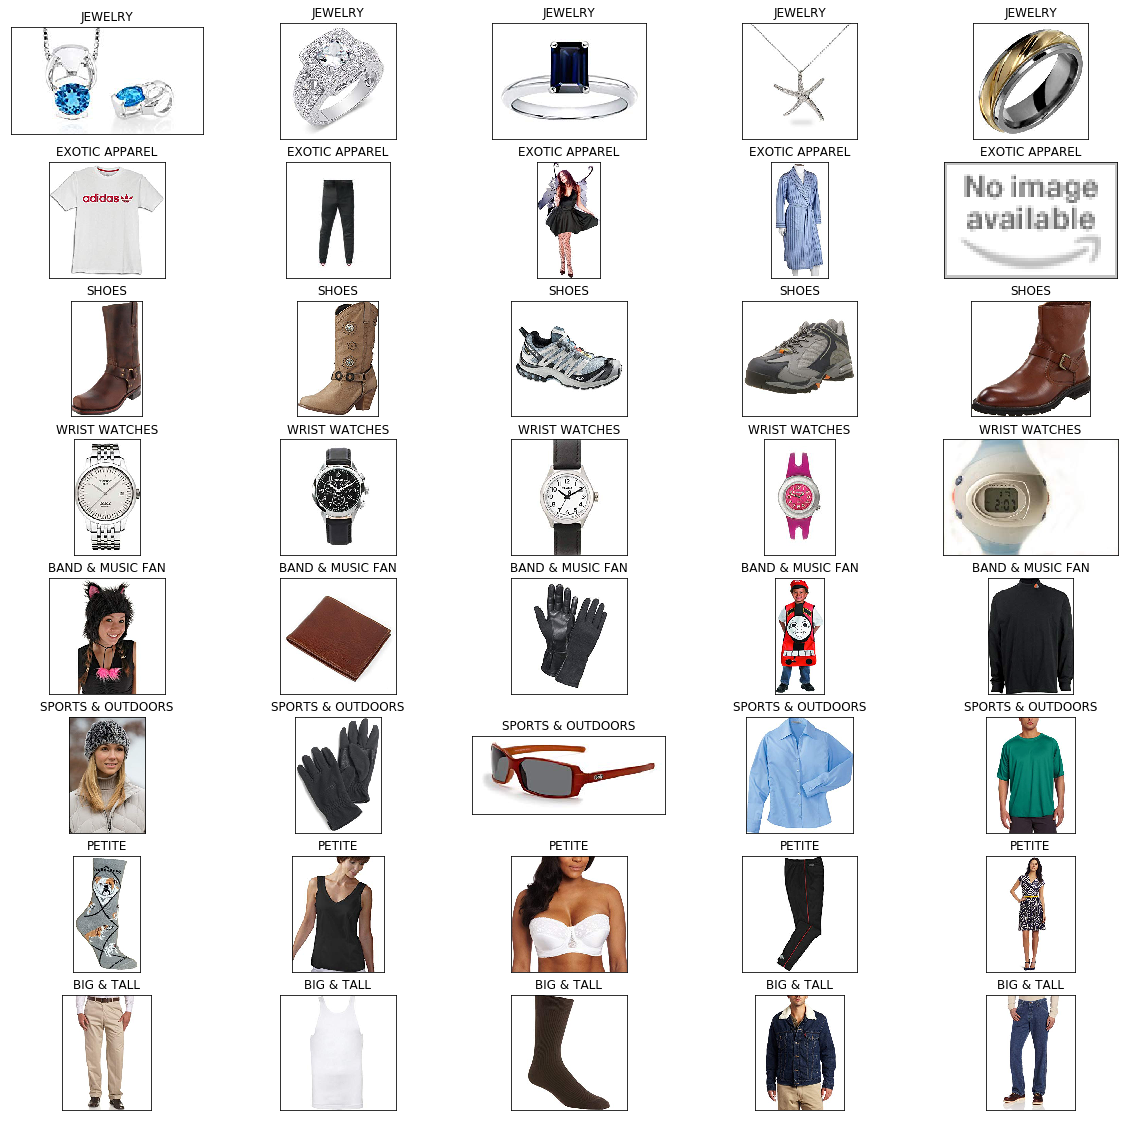

In [37]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import string

path_to_dir_with_label_dirs = './train'

list_of_labels = os.listdir(path_to_dir_with_label_dirs)

fig, axes = plt.subplots(len(list_of_labels),5, figsize=(20,20))

for r, label in enumerate(list_of_labels):
    current_label_dir_path = os.path.join(path_to_dir_with_label_dirs, label)
    list_of_images = os.listdir(current_label_dir_path)
    for c, image in enumerate(list_of_images[10:15]):
        current_image_path = os.path.join(current_label_dir_path, image)
        img = mpimg.imread(current_image_path)
        imgplot = axes[r][c].imshow(img)
        axes[r][c].get_xaxis().set_ticks([])
        axes[r][c].get_yaxis().set_ticks([])
        axes[r][c].set_title(label.upper())



<font color='red'>As can be seen there are some categories which have pretty specific images, like wrist watches, jewelry, shoes.
But there are also some categories which are not specific at all and contain multiple overlapping images, like Sports & Outdoors, Band & Music Fan, Petite, Big & Tall. </font>

## Get sizes of images

Images are not the same shape, so I found the median shape for most optimal shape to scale images into.

In [163]:
from PIL import Image

xs = []
ys = []

for image in onlyfiles:
    (x,y) =  Image.open('./Images/' + str(image) + '.jpg').size
    xs.append(x)
    ys.append(y)

In [164]:
import numpy as np
xs = np.array(xs)
ys = np.array(ys)


In [165]:
np.median(xs), np.median(ys)

(312.0, 300.0)

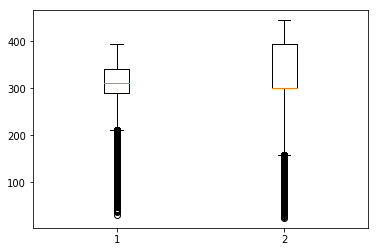

In [166]:
from matplotlib.pyplot import boxplot
import matplotlib.pyplot as plt


boxplot([xs,ys])
plt.show()

## Make data generators

These generators let's to read train images straight from directory and replaces the need to read every image into cache. 

In [41]:
from keras.preprocessing.image import ImageDataGenerator

input_shape = (150,150)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size= input_shape,
        batch_size=64,
        class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
        './val/',
        target_size=input_shape,
        batch_size=64,
        class_mode='sparse')
test_generator = test_datagen.flow_from_directory(
        './test/',
        target_size=input_shape,
        batch_size=64,
        class_mode='sparse')

Found 27164 images belonging to 8 classes.
Found 6787 images belonging to 8 classes.
Found 8491 images belonging to 8 classes.


## Define a network 1 — 1-Conv CNN

In [237]:
regulizer = keras.regularizers.l1(0.5)

In [229]:
import keras

input_shape = (150,150,3)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


cnn1 = Sequential()
cnn1.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape,kernel_regularizer=regulizer))
cnn1.add(MaxPooling2D(pool_size=(3, 3)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(16, activation='relu',kernel_regularizer=regulizer))
cnn1.add(Dense(8, activation='softmax'))

cnn1.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_108 (Dropout)        (None, 74, 74, 16)        0         
_________________________________________________________________
flatten_58 (Flatten)         (None, 87616)             0         
_________________________________________________________________
dense_118 (Dense)            (None, 16)                1401872   
_________________________________________________________________
dense_119 (Dense)            (None, 8)                 136       
Total params: 1,402,456
Trainable params: 1,402,456
Non-trainable params: 0
_________________________________________________________________


In [233]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

cnn1.fit_generator(
        train_generator,
        steps_per_epoch=300,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=200)

Epoch 1/50
300/300 [==============================] - 205s 682ms/step - loss: 123.8121 - acc: 0.3261 - val_loss: 125.0812 - val_acc: 0.3209
Epoch 2/50
300/300 [==============================] - 201s 671ms/step - loss: 123.7245 - acc: 0.3202 - val_loss: 123.2069 - val_acc: 0.3200
Epoch 3/50
300/300 [==============================] - 237s 789ms/step - loss: 123.6777 - acc: 0.3227 - val_loss: 124.4768 - val_acc: 0.3206
Epoch 4/50
300/300 [==============================] - 208s 693ms/step - loss: 123.6631 - acc: 0.3207 - val_loss: 124.8328 - val_acc: 0.3236
Epoch 5/50
300/300 [==============================] - 200s 665ms/step - loss: 123.6441 - acc: 0.3196 - val_loss: 124.4114 - val_acc: 0.3224
Epoch 6/50
300/300 [==============================] - 200s 667ms/step - loss: 123.6775 - acc: 0.3207 - val_loss: 123.9927 - val_acc: 0.3239
Epoch 7/50
300/300 [==============================] - 200s 666ms/step - loss: 123.6482 - acc: 0.3209 - val_loss: 125.0397 - val_acc: 0.3203
Epoch 8/50
300/300 [

KeyboardInterrupt: 

In [234]:
probabilities = cnn1.predict_generator(test_generator, steps=len(test_generator.filenames) /64)

In [235]:
import numpy as np
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(probabilities, axis=1), test_generator.classes)

0.3219879872806501

### Regularization 0.1

In [245]:
import keras

input_shape = (150,150,3)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

regulizer = regulizer = keras.regularizers.l1(0.1)

cnn1 = Sequential()
cnn1.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape,kernel_regularizer=regulizer))
cnn1.add(MaxPooling2D(pool_size=(3, 3)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(16, activation='relu',kernel_regularizer=regulizer))
cnn1.add(Dense(8, activation='softmax'))

cnn1.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
dropout_121 (Dropout)        (None, 49, 49, 16)        0         
_________________________________________________________________
flatten_62 (Flatten)         (None, 38416)             0         
_________________________________________________________________
dense_126 (Dense)            (None, 16)                614672    
_________________________________________________________________
dense_127 (Dense)            (None, 8)                 136       
Total params: 615,256
Trainable params: 615,256
Non-trainable params: 0
_________________________________________________________________


In [246]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

cnn1.fit_generator(
        train_generator,
        steps_per_epoch=300,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=200)

Epoch 1/50
300/300 [==============================] - 190s 634ms/step - loss: 19.4875 - acc: 0.3411 - val_loss: 8.8853 - val_acc: 0.3234
Epoch 2/50
300/300 [==============================] - 188s 627ms/step - loss: 8.6720 - acc: 0.3262 - val_loss: 8.5490 - val_acc: 0.3245
Epoch 3/50
300/300 [==============================] - 188s 627ms/step - loss: 8.5450 - acc: 0.3149 - val_loss: 8.5568 - val_acc: 0.3183
Epoch 4/50
300/300 [==============================] - 187s 625ms/step - loss: 8.5324 - acc: 0.3213 - val_loss: 8.4929 - val_acc: 0.3242
Epoch 5/50
300/300 [==============================] - 189s 630ms/step - loss: 8.5184 - acc: 0.3212 - val_loss: 8.5237 - val_acc: 0.3204
Epoch 6/50
300/300 [==============================] - 187s 622ms/step - loss: 8.5143 - acc: 0.3223 - val_loss: 8.5193 - val_acc: 0.3228
Epoch 7/50
300/300 [==============================] - 187s 622ms/step - loss: 8.5040 - acc: 0.3197 - val_loss: 8.5064 - val_acc: 0.3227
Epoch 8/50
300/300 [===========================

In [43]:
import keras

input_shape = (150,150,3)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

regulizer = regulizer = keras.regularizers.l1(0.1)

cnn1 = Sequential()
cnn1.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape,kernel_regularizer=regulizer))
cnn1.add(MaxPooling2D(pool_size=(3, 3)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(16, activation='relu',kernel_regularizer=regulizer))
cnn1.add(Dense(8, activation='softmax'))

cnn1.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 49, 49, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 38416)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                614672    
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
Total params: 615,256
Trainable params: 615,256
Non-trainable params: 0
_________________________________________________________________


In [45]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

cnn1.fit_generator(
        train_generator,
        steps_per_epoch=300,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=200)

Epoch 1/10
300/300 [==============================] - 328s 1s/step - loss: 8.6885 - acc: 0.3195 - val_loss: 8.6630 - val_acc: 0.3224
Epoch 2/10
300/300 [==============================] - 246s 821ms/step - loss: 8.6670 - acc: 0.3234 - val_loss: 8.6306 - val_acc: 0.3239
Epoch 3/10
300/300 [==============================] - 234s 781ms/step - loss: 8.6489 - acc: 0.3153 - val_loss: 8.6415 - val_acc: 0.3191
Epoch 4/10
300/300 [==============================] - 188s 626ms/step - loss: 8.6304 - acc: 0.3173 - val_loss: 8.6208 - val_acc: 0.3235
Epoch 5/10
300/300 [==============================] - 188s 628ms/step - loss: 8.5963 - acc: 0.3222 - val_loss: 8.5827 - val_acc: 0.3233
Epoch 6/10
300/300 [==============================] - 187s 624ms/step - loss: 8.5784 - acc: 0.3214 - val_loss: 8.5661 - val_acc: 0.3208
Epoch 7/10
300/300 [==============================] - 187s 624ms/step - loss: 8.5565 - acc: 0.3223 - val_loss: 8.5459 - val_acc: 0.3101
Epoch 8/10
300/300 [==============================]

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
probabilities = cnn1.predict_generator(test_generator, steps=len(test_generator.filenames) /64)

accuracy_score(np.argmax(probabilities, axis=1), test_generator.classes)

0.3219879872806501

In [54]:
confusion_matrix(test_generator.classes, np.argmax(probabilities, axis=1))

array([[   0,    0,    0,    0,    0,  529,    0,    0],
       [   0,    0,    0,    0,    0,  475,    0,    0],
       [   0,    0,    0,    0,    0,  198,    0,    0],
       [   0,    0,    0,    0,    0, 2626,    0,    0],
       [   0,    0,    0,    0,    0,  618,    0,    0],
       [   0,    0,    0,    0,    0, 2734,    0,    0],
       [   0,    0,    0,    0,    0,  222,    0,    0],
       [   0,    0,    0,    0,    0, 1089,    0,    0]])

# Models below are extremely overfitted reporting training and validation accuracy close to 0.8 but test accuracy just 0.24

## 2 — 3-Conv CNN

In [40]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

input_shape = (150,150,3)

regulizer = regulizer = keras.regularizers.l1(0.1)

cnn3 = Sequential()
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,kernel_regularizer=regulizer))
cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regulizer))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regulizer))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(32, activation='relu',kernel_regularizer=regulizer))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(8, activation='softmax'))

cnn3.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
cnn3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
__________

In [42]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

cnn3.fit_generator(
        train_generator,
        steps_per_epoch=300,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=200)

Epoch 1/10
300/300 [==============================] - 618s 2s/step - loss: 73.2022 - acc: 0.3163 - val_loss: 31.0921 - val_acc: 0.3102
Epoch 2/10
300/300 [==============================] - 5181s 17s/step - loss: 30.4902 - acc: 0.3176 - val_loss: 30.5495 - val_acc: 0.3213
Epoch 3/10
300/300 [==============================] - 819s 3s/step - loss: 30.1359 - acc: 0.3169 - val_loss: 30.3587 - val_acc: 0.3210
Epoch 4/10
 74/300 [======>.......................] - ETA: 8:49 - loss: 29.9340 - acc: 0.3193

KeyboardInterrupt: 

In [243]:
probabilities = cnn3.predict_generator(test_generator, steps=len(test_generator.filenames) /64)

accuracy_score(np.argmax(probabilities, axis=1), test_generator.classes)

0.3092686373807561

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## 3 — 4-Conv CNN

In [131]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

cnn4 = Sequential()
cnn4.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Flatten())

cnn4.add(Dense(64, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Dense(8, activation='softmax'))

cnn4.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
cnn4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization_25 (Batc (None, 148, 148, 16)      64        
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 146, 146, 16)      2320      
_________________________________________________________________
batch_normalization_26 (Batc (None, 146, 146, 16)      64        
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 71, 71, 32)        4640      
__________

In [133]:
cnn4.fit_generator(
        train_generator,
        steps_per_epoch=300,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=200)

Epoch 1/10
300/300 [==============================] - 674s 2s/step - loss: 1.0570 - acc: 0.6837 - val_loss: 6.3163 - val_acc: 0.4009
Epoch 2/10
300/300 [==============================] - 670s 2s/step - loss: 0.8247 - acc: 0.7459 - val_loss: 7.5092 - val_acc: 0.3182
Epoch 3/10
300/300 [==============================] - 680s 2s/step - loss: 0.7356 - acc: 0.7720 - val_loss: 3.8820 - val_acc: 0.3428
Epoch 4/10
300/300 [==============================] - 674s 2s/step - loss: 0.6859 - acc: 0.7842 - val_loss: 2.9596 - val_acc: 0.4531
Epoch 5/10
300/300 [==============================] - 675s 2s/step - loss: 0.6695 - acc: 0.7878 - val_loss: 4.8402 - val_acc: 0.2519
Epoch 6/10
300/300 [==============================] - 674s 2s/step - loss: 0.6343 - acc: 0.7979 - val_loss: 4.7241 - val_acc: 0.4878
Epoch 7/10
300/300 [==============================] - 675s 2s/step - loss: 0.6242 - acc: 0.7995 - val_loss: 7.1096 - val_acc: 0.1963
Epoch 8/10
300/300 [==============================] - 674s 2s/step - 

In [134]:
probabilities = cnn4.predict_generator(test_generator, steps=len(test_generator.filenames) /32)

accuracy_score(np.argmax(probabilities, axis=1), test_generator.classes)

0.24472971381462724